# 10x scRNA-seq analysis pipeline module 1

__In this notebook we will import the raw count matrix ([Per-molecule read information](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/overview) ) and do some basic inspection of read distributions as well as indentify empty droplets and doublets__ 

__INPUT__  
>>raw count matrix (i.e. H5 file) 


__OUTPUT__
>>[R singlecell data object](https://bioconductor.org/packages/release/bioc/vignettes/SingleCellExperiment/inst/doc/intro.html) conataining raw reads -- after exclusion of empty droplets, doublets, cells with high fraction of mt-RNA, and genes with low total read count  
covariate file inculding fraction mtRNA and the library size (total UMI count) of each cell



In [1]:
rm(list=ls())
sessionInfo()
getwd()
#setwd("/gpfs/data/fs71707/dsam/DARC//DARC/notebooks/")

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.3     crayon_1.5.2    digest_0.6.29   utf8_1.2.2     
 [5] IRdisplay_1.1   repr_1.1.4      lifecycle_1.0.2 jsonlite_1.8.2 
 [9] evaluate_0.16   pillar_1.8.1    rlang_1.0.6     cli_3.4.1      
[13] uuid_1.1-0      vctrs_0.

[1] "/gpfs/data/fs71707/dsam/DARC/DARC/notebooks/AD_notebooks"

In [2]:
### looks like it has to be loaded in exact this order !!!!!
library(Seurat)
library("BiocGenerics",lib.loc = "/home/fs71707/dsam/R_packages/")
library("S4Vectors",lib.loc = "/home/fs71707/dsam/R_packages/")
library("IRanges",lib.loc = "/home/fs71707/dsam/R_packages/")
library("GenomeInfoDb",lib.loc = "/home/fs71707/dsam/R_packages/")
library("Biobase",lib.loc = "/home/fs71707/dsam/R_packages/")
library("GenomeInfoDb",lib.loc = "/home/fs71707/dsam/R_packages/")
library("IRanges",lib.loc = "/home/fs71707/dsam/R_packages/")
library("S4Vectors",lib.loc = "/home/fs71707/dsam/R_packages/")
library("matrixStats",lib.loc = "/home/fs71707/dsam/R_packages/")
library("MatrixGenerics",lib.loc = "/home/fs71707/dsam/R_packages/")
library("BiocGenerics",lib.loc = "/home/fs71707/dsam/R_packages/")
library("GenomicRanges",lib.loc = "/home/fs71707/dsam/R_packages/")
library("MatrixGenerics",lib.loc = "/home/fs71707/dsam/R_packages/")
library("matrixStats",lib.loc = "/home/fs71707/dsam/R_packages/")
library("MatrixGenerics",lib.loc = "/home/fs71707/dsam/R_packages/")
library("SummarizedExperiment",lib.loc = "/home/fs71707/dsam/R_packages/")
library("SingleCellExperiment",lib.loc = "/home/fs71707/dsam/R_packages/")
library("scuttle",lib.loc = "/home/fs71707/dsam/R_packages2/")
library("scran",lib.loc = "/home/fs71707/dsam/R_packages2/")
library("DropletUtils", lib.loc = "/home/fs71707/dsam/R_packages2/")
library("limma",lib.loc = "/home/fs71707/dsam/R_packages/")
library("BiocGenerics",lib.loc = "/home/fs71707/dsam/R_packages/")
library("AnnotationDbi",lib.loc = "/home/fs71707/dsam/R_packages2/")
library("org.Hs.eg.db",lib.loc = "/home/fs71707/dsam/R_packages2/")
library("SummarizedExperiment",lib.loc = "/home/fs71707/dsam/R_packages/")
library("ggplot2",lib.loc = "/home/fs71707/dsam/R_packages/")

Attaching SeuratObject

Attaching sp


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname



Attaching package: ‘IRanges’


The following object is masked from ‘package:sp’:

    %over%


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citat

In [3]:
dir=c("/home/fs71707/dsam/data/DARC/DARC/data_june23/AD8_transcriptome/AD8rec/filtered_feature_bc_matrix/")
out=c("/home/fs71707/dsam/data/DARC/DARC/result/")
inter.dat=c("/home/fs71707/dsam/data/DARC/DARC/proc_data/")
w.dir=c("/home/fs71707/dsam/data/DARC/DARC/notebooks/")
sample_ID=c("AD8rec")
## make a QC-overview file

metrics=c("input_file","background_FDR","cells", "mitochRNA_thresh","mitochRNA_excl",
          "doublets","cells_post_QC","genes_post_QC","umi_per_gene","genes_per_cell","UMI_per_cell","UMIs_in_top50_in_perc","HVG_thresh_type","HVG_thresh",
         "HVG","PCs","PCs_assocTECH","resolution","cluster","diffGenes_total")
overview=data.frame(metric=rep(NA,length(metrics)),sample=rep(NA,length(metrics)))
colnames(overview)[2]=c(sample_ID)
row.names(overview)=overview$metric=as.character(metrics)
overview["input_file",2]=as.character(dir)
####. -------  we need to convert all gene IDs to standardised NCBI IDs 
file.exists(paste0(w.dir,"Homo_sapiens.gene_info"))             

[1] TRUE

In [4]:
sce = read10xCounts(paste(dir))

as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead



In [5]:
dim(sce)
head(sce)
head(rowData(sce))

[1] 36601  4740

class: SingleCellExperiment 
dim: 6 4740 
metadata(1): Samples
assays(1): counts
rownames(6): ENSG00000243485 ENSG00000237613 ... ENSG00000239945
  ENSG00000239906
rowData names(3): ID Symbol Type
colnames: NULL
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

DataFrame with 6 rows and 3 columns
                             ID      Symbol            Type
                    <character> <character>     <character>
ENSG00000243485 ENSG00000243485 MIR1302-2HG Gene Expression
ENSG00000237613 ENSG00000237613     FAM138A Gene Expression
ENSG00000186092 ENSG00000186092       OR4F5 Gene Expression
ENSG00000238009 ENSG00000238009  AL627309.1 Gene Expression
ENSG00000239945 ENSG00000239945  AL627309.3 Gene Expression
ENSG00000239906 ENSG00000239906  AL627309.2 Gene Expression

### convert to NCBI SYMBOL

In [6]:
#library("AnnotationDbi",lib.loc = "/home/fs71707/mwielsch1/Jupyter-R/R_only/")
#library("org.Hs.eg.db",lib.loc = "/home/fs71707/mwielsch1/Jupyter-R/R_only/") SCHON GELADEN
r.names=as.vector(rownames(sce))
annots = select(org.Hs.eg.db, keys=r.names, columns="SYMBOL", keytype="ENSEMBL")
annots1=annots[!duplicated(annots$ENSEMBL),]       ##### here we remove the second Symbol entry per ENSG entry
rownames(annots1)= as.character(annots1$ENSEMBL)
annots1=annots1[as.character(r.names),]
head(annots1)
annots1$new = ifelse(is.na(annots1$SYMBOL), as.character(annots1$ENSEMBL), annots1$SYMBOL)
head(annots1)
length(r.names)
head(r.names)
dim(annots1)
table(is.na(annots1$SYMBOL))

'select()' returned 1:many mapping between keys and columns



,ENSEMBL,SYMBOL
,<chr>,<chr>
ENSG00000243485,ENSG00000243485,NA
ENSG00000237613,ENSG00000237613,FAM138A
ENSG00000186092,ENSG00000186092,OR4F5
ENSG00000238009,ENSG00000238009,LOC100996442
ENSG00000239945,ENSG00000239945,NA
ENSG00000239906,ENSG00000239906,NA


,ENSEMBL,SYMBOL,new
,<chr>,<chr>,<chr>
ENSG00000243485,ENSG00000243485,NA,ENSG00000243485
ENSG00000237613,ENSG00000237613,FAM138A,FAM138A
ENSG00000186092,ENSG00000186092,OR4F5,OR4F5
ENSG00000238009,ENSG00000238009,LOC100996442,LOC100996442
ENSG00000239945,ENSG00000239945,NA,ENSG00000239945
ENSG00000239906,ENSG00000239906,NA,ENSG00000239906


[1] 36601

[1] "ENSG00000243485" "ENSG00000237613" "ENSG00000186092" "ENSG00000238009"
[5] "ENSG00000239945" "ENSG00000239906"

[1] 36601     3


FALSE  TRUE 
23787 12814 

In [7]:
rowData(sce)$NCBI_clean=as.character(annots1$new)
head(rowData(sce))

DataFrame with 6 rows and 4 columns
                             ID      Symbol            Type      NCBI_clean
                    <character> <character>     <character>     <character>
ENSG00000243485 ENSG00000243485 MIR1302-2HG Gene Expression ENSG00000243485
ENSG00000237613 ENSG00000237613     FAM138A Gene Expression         FAM138A
ENSG00000186092 ENSG00000186092       OR4F5 Gene Expression           OR4F5
ENSG00000238009 ENSG00000238009  AL627309.1 Gene Expression    LOC100996442
ENSG00000239945 ENSG00000239945  AL627309.3 Gene Expression ENSG00000239945
ENSG00000239906 ENSG00000239906  AL627309.2 Gene Expression ENSG00000239906

In [8]:
rownames(sce)= as.character(rowData(sce)$Symbol)
head(sce)
head(rownames(sce),n=100)

class: SingleCellExperiment 
dim: 6 4740 
metadata(1): Samples
assays(1): counts
rownames(6): MIR1302-2HG FAM138A ... AL627309.3 AL627309.2
rowData names(4): ID Symbol Type NCBI_clean
colnames: NULL
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

[1] "MIR1302-2HG" "FAM138A"     "OR4F5"       "AL627309.1"  "AL627309.3" 
  [6] "AL627309.2"  "AL627309.5"  "AL627309.4"  "AP006222.2"  "AL732372.1" 
 [11] "OR4F29"      "AC114498.1"  "OR4F16"      "AL669831.2"  "LINC01409"  
 [16] "FAM87B"      "LINC01128"   "LINC00115"   "FAM41C"      "AL645608.6" 
 [21] "AL645608.2"  "AL645608.4"  "LINC02593"   "SAMD11"      "NOC2L"      
 [26] "KLHL17"      "PLEKHN1"     "PERM1"       "AL645608.7"  "HES4"       
 [31] "ISG15"       "AL645608.1"  "AGRN"        "AL645608.5"  "AL645608.8" 
 [36] "RNF223"      "C1orf159"    "AL390719.3"  "LINC01342"   "AL390719.2" 
 [41] "TTLL10-AS1"  "TTLL10"      "TNFRSF18"    "TNFRSF4"     "SDF4"       
 [46] "B3GALT6"     "C1QTNF12"    "AL162741.1"  "UBE2J2"      "LINC01786"  
 [51] "SCNN1D"      "ACAP3"       "PUSL1"       "INTS11"      "AL139287.1" 
 [56] "CPTP"        "TAS1R3"      "DVL1"        "MXRA8"       "AURKAIP1"   
 [61] "CCNL2"       "MRPL20-AS1"  "MRPL20"      "AL391244.2"  "ANKRD65"    
 [66] "AL391244.1"  "TMEM88B"     "LINC01770"   "VWA1"        "ATAD3C"     
 [71] "ATAD3B"      "ATAD3A"      "TMEM240"     "SSU72"       "AL645728.1" 
 [76] "FNDC10"      "AL691432.4"  "AL691432.2"  "MIB2"        "MMP23B"     
 [81] "CDK11B"      "FO704657.1"  "SLC35E2B"    "CDK11A"      "SLC35E2A"   
 [86] "NADK"        "GNB1"        "AL109917.1"  "CALML6"      "TMEM52"     
 [91] "CFAP74"      "AL391845.2"  "GABRD"       "AL391845.1"  "PRKCZ"      
 [96] "AL590822.2"  "PRKCZ-AS1"   "FAAP20"      "AL590822.1"  "SKI"

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in plot.histogram(r, freq = freq1, col = col, border = border, angle = angle, :
“the AREAS in the plot are wrong -- rather use 'freq = FALSE'”
Warning message in plot.histogram(r, freq = freq1, col = col, border = border, angle = angle, :
“the AREAS in the plot are wrong -- rather use 'freq = FALSE'”


png 
  2


FALSE  TRUE 
  471  4269 

[1] 36601  4488

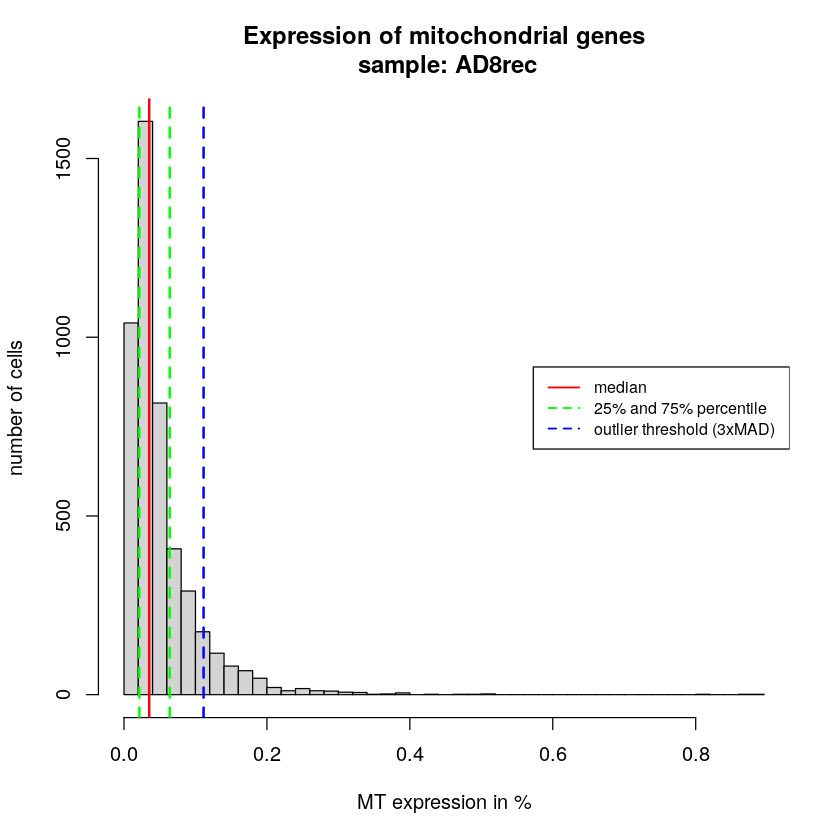

In [9]:
is.mito=grepl("MT-",rownames(sce))
perc_mt=apply(sce@assays@data$counts,2,function(x) sum(x[is.mito]/sum(x)))
a=c(seq(0,1,by=0.02)[1:length(seq(0,max(perc_mt),by=0.02))-1],max(perc_mt))
hist(perc_mt,breaks=a,freq=T,main=paste("Expression of mitochondrial genes\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("MT expression in %"))
abline(v=median(perc_mt),col="red",lwd=2)
abline(v=quantile(perc_mt,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(perc_mt,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
abline(v=(median(perc_mt)+3*(mad(perc_mt))),col="blue",lty=2,lwd=2)
legend("right", legend=c("median", "25% and 75% percentile","outlier threshold (3xMAD)"),
       col=c("red", "green","blue"), lty=c(1,2,2),lwd=1.5, cex=0.8)
              
#######.   ------------------------------------
jpeg(paste0(out,sample_ID,"_mtRNA.jpeg"))
hist(perc_mt,breaks=a,freq=T,main=paste("Expression of mitochondrial genes\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("MT expression in %"))
abline(v=median(perc_mt),col="red",lwd=2)
abline(v=quantile(perc_mt,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(perc_mt,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
abline(v=(median(perc_mt)+3*(mad(perc_mt))),col="blue",lty=2,lwd=2)
legend("right", legend=c("median", "25% and 75% percentile","outlier threshold (3xMAD)"),
       col=c("red", "green","blue"), lty=c(1,2,2),lwd=1.5, cex=0.8)
              
dev.off()             
              
## ------------     check and subset
table(perc_mt < (median(perc_mt)+3*(mad(perc_mt))))
thresh=median(perc_mt)+3*(mad(perc_mt))
thresh=0.15
exclude_mtDNA=table(perc_mt < thresh)[1]            
sce1=sce[,perc_mt < thresh]
overview["mitochRNA_thresh",2]=thresh
overview["mitochRNA_excl",2]=exclude_mtDNA
dim(sce1)

### remove Doublets 

[Doublet cells](https://ltla.github.io/SingleCellThoughts/software/doublet_detection/bycell.html) for each cell are simultated and compared to the actual neighboing cells of the tested cell (this makes a score)
* Force match corrects for RNA content of cells  
* size factors and normalization is computed internally to avoid confusion  
* This is what happens:  
> 1. Simulate thousands of doublets by adding together two randomly chosen single-cell profiles.  
> 2. For each original cell, compute the density of simulated doublets in the surrounding neighbourhood.  
> 3. For each original cell, compute the density of other observed cells in the neighbourhood.  
> 4. Return the ratio between the two densities as a “doublet score” for each cell.  


so let's say we simmulated douplet cells
> now for a particular cell we are looking at 100 neighbors  
> densitiy of doublets for this cell is 30 that makes 30/100   
> density of other cells is 70/100 than makes 70/100  
> makes a score of 0.4 -- log10 of that  
>> as the number of other cells goes down the score goes up  
> process number of neigbors = now 200  
  
__cutoff should be around 4__

In [10]:
library("scDblFinder",lib.loc = "/home/fs71707/dsam/R_packages2/")

[1] "in sample QC process we excluded 252 samples due to hight Mitochondrial DNA proportion and 3 potential Doublet cells"

[1] "that leaves  4485 cells for further analysis"

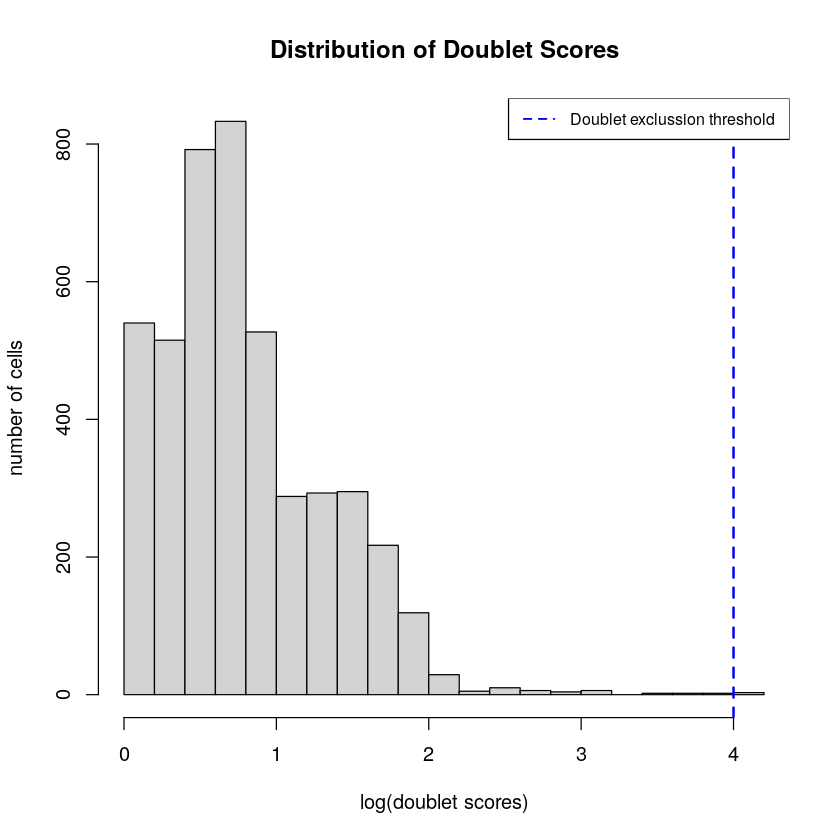

In [11]:
doublet_score=scDblFinder::computeDoubletDensity(sce1, k = 200)
doub_score=doublet_score
thresh=median(doub_score)+3*mad(doub_score)
thresh=4
hist(doub_score,breaks=25,main="Distribution of Doublet Scores",xlab="log(doublet scores)",ylab=c("number of cells"))
abline(v=thresh,col="blue",lty=2,lwd=2)
legend("topright", legend=c("Doublet exclussion threshold"),
       col=c("blue"), lty=c(2),lwd=1.5, cex=0.8)

exclude_doublet=table(doub_score<thresh)[1]
sce2=sce1[,doub_score<thresh]
paste("in sample QC process we excluded",exclude_mtDNA,"samples due to hight Mitochondrial DNA proportion and",
      exclude_doublet,"potential Doublet cells",sep=" ")
paste("that leaves ", dim(sce2)[2], "cells for further analysis")
overview["doublets",2]=exclude_doublet
#  --------------------------------------------------------    remove mitochndrial RNA assays 
#is.mito=grepl("MT-",rownames(sce2@assays@data$counts))
#perc_mt1=apply(sce2@assays@data$counts,2,function(x) sum(x[is.mito]/sum(x)))
#paste("we excluded", table(grepl("MT-",rownames(sce2@assays@data$counts)))[2],"mitochondiral genes",sep=" ")
#sce2=sce2[!(grepl("MT-",rownames(sce2@assays@data$counts))),]
## --------------------------------------------------------------

In [12]:
exclude_doublet=table(doub_score<thresh)[1]
sce2=sce1[,doub_score<thresh]
paste("in sample QC process we excluded",exclude_mtDNA,"samples due to hight Mitochondrial DNA proportion and",
      exclude_doublet,"potential Doublet cells",sep=" ")
paste("that leaves ", dim(sce2)[2], "cells for further analysis")
overview["doublets",2]=exclude_doublet

[1] "in sample QC process we excluded 252 samples due to hight Mitochondrial DNA proportion and 3 potential Doublet cells"

[1] "that leaves  4485 cells for further analysis"

### UMI per cell (library size)

In [13]:
umi_per_cell=apply(sce@assays@data$counts,2,sum)
median(umi_per_cell)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”


[1] 2651

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”


png 
  2

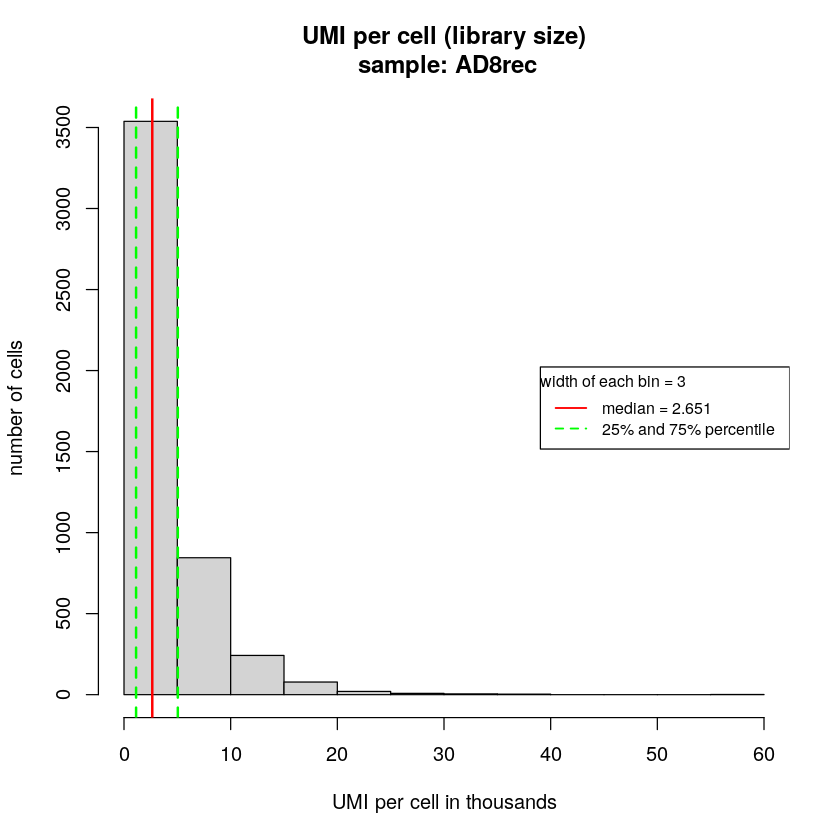

In [14]:
umi_per_cell=apply(sce@assays@data$counts,2,sum)
lib_size_mad=mad(umi_per_cell)
a=c(seq(0,max(umi_per_cell/1000),by=3)[1:length(seq(0,max(umi_per_cell/1000),by=3))-1],max(umi_per_cell/1000))
options(warn=-1)
hist(umi_per_cell/1000,freq=T,
     main=paste("UMI per cell (library size)\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("UMI per cell in thousands"))
abline(v=median(umi_per_cell/1000),col="red",lwd=2)
abline(v=quantile(umi_per_cell/1000,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(umi_per_cell/1000,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
#abline(v=(median(umi_per_cell)+5*(mad(umi_per_cell)))/1000,col="blue",lty=2,lwd=2)
legend("right", legend=c(paste0("median = ",median(umi_per_cell/1000)), "25% and 75% percentile"),
       col=c("red", "green"), lty=1:2,lwd=1.5, cex=0.8, title="width of each bin = 3",title.adj=0)

jpeg(paste0(out,sample_ID,"_LIBRARY_SIZE.jpeg"))
hist(umi_per_cell/1000,breaks=a,freq=T,
     main=paste("UMI per cell (library size)\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("UMI per cell in thousands"))
abline(v=median(umi_per_cell/1000),col="red",lwd=2)
abline(v=quantile(umi_per_cell/1000,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(umi_per_cell/1000,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
#abline(v=(median(umi_per_cell)+5*(mad(umi_per_cell)))/1000,col="blue",lty=2,lwd=2)
legend("right", legend=c(paste0("median = ",median(umi_per_cell/1000)), "25% and 75% percentile"),
       col=c("red", "green"), lty=1:2,lwd=1.5, cex=0.8, title="width of each bin = 3",title.adj=0)

dev.off()

### Genes per cell

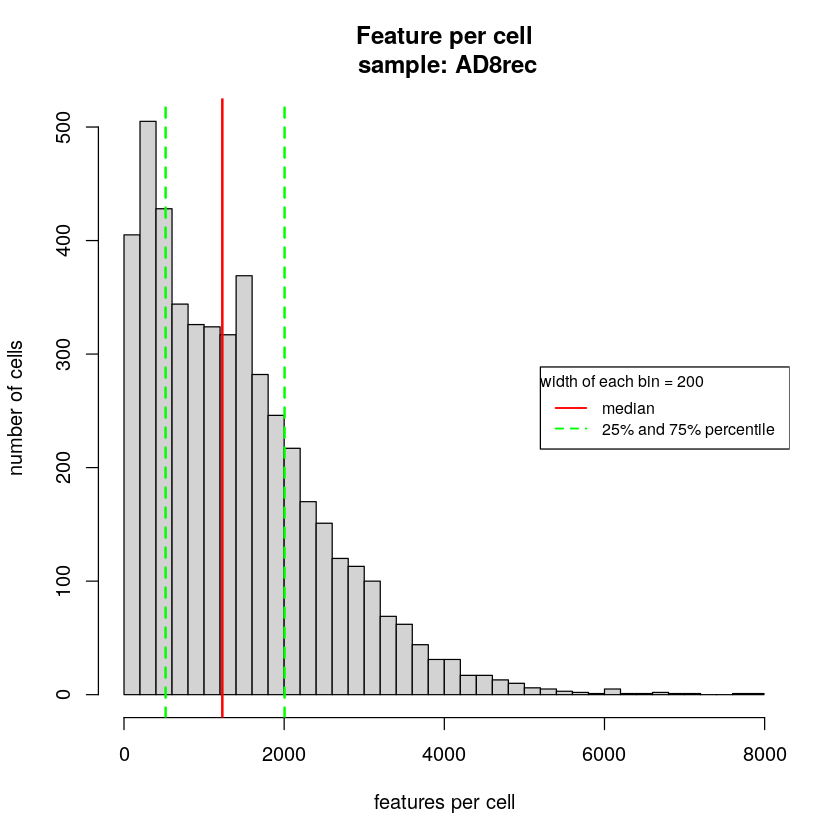

In [15]:
feature_per_cell=apply(sce@assays@data$counts,2,function(x)table(x %in% c(0))[1])

a=c(seq(0,max(feature_per_cell),by=200)[1:length(seq(0,max(feature_per_cell),by=200))-1],max(feature_per_cell))
hist(feature_per_cell,breaks=a,freq=T,
     main=paste("Feature per cell\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("features per cell"))
abline(v=median(feature_per_cell),col="red",lwd=2)
abline(v=quantile(feature_per_cell,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(feature_per_cell,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
legend("right", legend=c("median", "25% and 75% percentile"),
       col=c("red", "green"), lty=1:2,lwd=1.5, cex=0.8, title="width of each bin = 200",title.adj=0)

## saturation plot  
>should get flat at the right end  
>if it looks linear --  coverage is too low

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



png 
  2

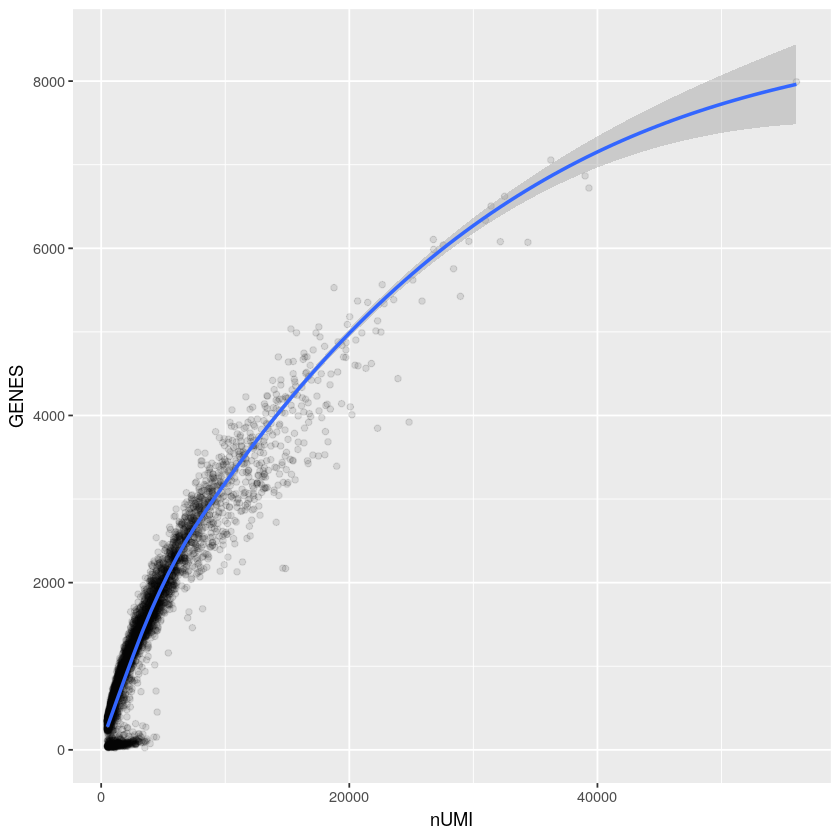

In [16]:
#library("ggplot2",lib.loc = "/home/fs71707/mwielsch1/Jupyter-R/R_only/")
overview["UMI_per_cell",2]=mean(umi_per_cell)
overview["genes_per_cell",2]=mean(feature_per_cell)
sat=as.data.frame(cbind(feature_per_cell,umi_per_cell))
sat=sat[order(sat$feature_per_cell),]
colnames(sat)=c("GENES","nUMI")
p=ggplot(sat,aes(x=nUMI,y=GENES)) +
geom_point(alpha=0.1)+
stat_smooth(method=loess)
p
jpeg(paste0(out,sample_ID,"_saturation.jpeg"))
print(p)
dev.off()

> #### UMI per feature

png 
  2

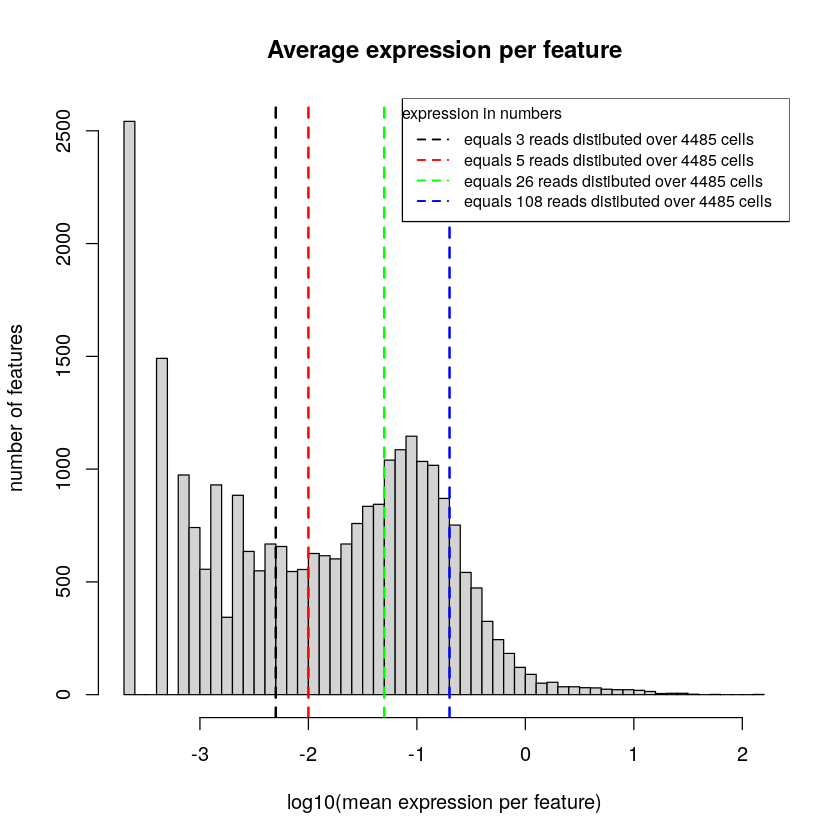

In [17]:
umi_per_feature=apply(sce2@assays@data$counts,1,sum)
ave_per_feature=apply(sce2@assays@data$counts,1,mean)
total=dim(sce2)[2]
one=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.2)]),digits=1)
two=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.05)]),digits=1)
drei=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.01)]),digits=1)
four=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.005)]),digits=1)

hist(log10(ave_per_feature),breaks=50,main=c("Average expression per feature"),xlab=c("log10(mean expression per feature)"),
     ylab=c("number of features"))
abline(v=log10(0.2),col="blue",lty=2,lwd=2)
abline(v=log10(0.05),col="green",lty=2,lwd=2)
abline(v=log10(0.01),col="red",lty=2,lwd=2)
abline(v=log10(0.005),col="black",lty=2,lwd=2)

legend("topright", legend=c(paste("equals",four,"reads distibuted over",total,"cells"), 
                            paste("equals",drei,"reads distibuted over",total,"cells"),
                            paste("equals",two,"reads distibuted over",total,"cells"),
                            paste("equals",one,"reads distibuted over",total,"cells")),
       col=c("black", "red","green","blue"), lty=c(2),lwd=1.5, cex=0.8, title="expression in numbers",title.adj=0)

jpeg(paste0(out,sample_ID,"_UMI_per_feature.jpeg"))
hist(log10(ave_per_feature),breaks=50,main=c("Average expression per feature"),xlab=c("log10(mean expression per feature)"),
     ylab=c("number of features"))
abline(v=log10(0.2),col="blue",lty=2,lwd=2)
abline(v=log10(0.05),col="green",lty=2,lwd=2)
abline(v=log10(0.01),col="red",lty=2,lwd=2)
abline(v=log10(0.005),col="black",lty=2,lwd=2)

legend("topright", legend=c(paste("equals",four,"reads distibuted over",total,"cells"), 
                            paste("equals",drei,"reads distibuted over",total,"cells"),
                            paste("equals",two,"reads distibuted over",total,"cells"),
                            paste("equals",one,"reads distibuted over",total,"cells")),
       col=c("black", "red","green","blue"), lty=c(2),lwd=1.5, cex=0.8, title="expression in numbers",title.adj=0)

dev.off()

In [18]:
log10(0.001)

[1] -3

In [19]:
thresh1=c(0.001)
paste("applying a threshold of",thresh1, "will remove",table(log10(ave_per_feature)>log10(thresh1))[1], "genes",sep=" ")
paste(" and leave",table(log10(ave_per_feature)>log10(thresh1))[2],"in our analysis",sep=" ")
overview["genes_post_QC",2]=table(log10(ave_per_feature)>log10(thresh1))[2]
sce3=sce2[log10(ave_per_feature)>log10(thresh1),] 

[1] "applying a threshold of 0.001 will remove 16046 genes"

[1] " and leave 20555 in our analysis"

In [20]:
dim(sce) #ROH
dim(sce1) #ohne Mt
dim(sce2) #ohne dbl
dim(sce3) #ohne zu niedrig expr gene

[1] 36601  4740

[1] 36601  4488

[1] 36601  4485

[1] 20555  4485

In [21]:
head(sce3)
umi_per_cell=apply(sce3@assays@data$counts,2,sum)
head(umi_per_cell)

class: SingleCellExperiment 
dim: 6 4485 
metadata(1): Samples
assays(1): counts
rownames(6): AL627309.5 LINC01409 ... SAMD11 NOC2L
rowData names(4): ID Symbol Type NCBI_clean
colnames: NULL
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

[1]  3018  3648  1882  4166 14115  7711

In [22]:
table(umi_per_cell<1000)[1]
sce4=sce3[,umi_per_cell>999]
dim(sce3)
dim(sce4)
overview["cells_post_QC",2]=dim(sce4)[2]

FALSE 
 3609

[1] 20555  4485

[1] 20555  3609

In [23]:
dim(sce) #ROH
dim(sce1) #ohne Mt
dim(sce2) #ohne dbl
dim(sce3) #ohne zu niedrig expr gene
dim(sce4) #umi gefiltert

[1] 36601  4740

[1] 36601  4488

[1] 36601  4485

[1] 20555  4485

[1] 20555  3609

In [24]:
save(inter.dat, file=paste0(inter.dat,"initialQC_",sample_ID,".RData"))

In [25]:
save(sce4,file=paste0(inter.dat,"initialQC_",sample_ID,".RData"))
umi_per_feature=apply(sce4@assays@data$counts,1,sum)
overview["umi_per_gene",2]=median(umi_per_feature)
write.table(overview,file=paste0(inter.dat,"initialQC_",sample_ID,".txt"),sep="\t",col.names=T,row.names=F,quote=F)

# restart and change to Seurat Image 

In [26]:
library(Seurat)
library("SingleCellExperiment",lib.loc="/home/fs71707/dsam/R_packages/", character.only=TRUE)
#library("dplyr",lib.loc="/home/fs71707/dsam/R_packages/", character.only=TRUE)
library("ggplot2", lib.loc ="/home/fs71707/dsam/R_packages/", character.only=TRUE)
#library("ggtree", lib.loc="/home/fs71707/dsam/R_packages/", character.only=TRUE)
library("cowplot", lib.loc="/home/fs71707/dsam/R_packages/", character.only=TRUE)
library("pROC",lib.loc = "/home/fs71707/dsam/R_packages2/", character.only = TRUE)
library("Matrix",lib.loc = "/home/fs71707/dsam/R_packages2", character.only = TRUE)
library("enrichR",lib.loc = "/home/fs71707/dsam/R_packages2", character.only = TRUE)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:IRanges’:

    cov, var


The following objects are masked from ‘package:S4Vectors’:

    cov, var


The following object is masked from ‘package:BiocGenerics’:

    var


The following objects are masked from ‘package:stats’:

    cov, smooth, var




ERROR: Error in value[[3L]](cond): Package ‘Matrix’ version 1.5.1 cannot be unloaded:
 Error in unloadNamespace(package) : namespace ‘Matrix’ is imported by ‘irlba’, ‘BiocSingular’, ‘HDF5Array’, ‘bluster’, ‘survival’, ‘BiocNeighbors’, ‘DelayedMatrixStats’, ‘uwot’, ‘leiden’, ‘spatstat.data’, ‘sctransform’, ‘spatstat.sparse’, ‘scuttle’, ‘mgcv’, ‘scater’, ‘SummarizedExperiment’, ‘SeuratObject’, ‘sparseMatrixStats’, ‘spatstat.core’, ‘beachmat’, ‘DelayedArray’, ‘rsvd’, ‘Seurat’, ‘scran’, ‘xgboost’, ‘ScaledMatrix’, ‘DropletUtils’, ‘scDblFinder’, ‘reticulate’ so cannot be unloaded



In [27]:
library("dplyr",lib.loc="/home/fs71707/dsam/R_packages2/", character.only=TRUE)


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:matrixStats’:

    count


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [28]:
library("ggtree", lib.loc="/home/fs71707/dsam/R_packages2/", character.only=TRUE)

Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

ggtree v3.2.1  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution. 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628




Attaching package: ‘ggtree’


The following object is masked from ‘package:IRanges’:

    collapse


The foll

In [29]:
dir=c("/home/fs71707/dsam/data/DARC/DARC/data_june23/AD8_transcriptome/AD8rec/filtered_feature_bc_matrix/")
out=c("/home/fs71707/dsam/data/DARC/DARC/result/")
inter.dat=c("/home/fs71707/dsam/data/DARC/DARC/proc_data/")
w.dir=c("/home/fs71707/dsam/data/DARC/DARC/notebooks/")
sample_ID=c("AD8rec")

In [30]:
overview=read.table(paste0(inter.dat,"initialQC_",sample_ID,".txt"),header=T)
rownames(overview)=as.character(overview$metric)
load(paste0(inter.dat,"initialQC_",sample_ID,".RData"))
ls()
head(overview)

[1] "a"                "annots"           "annots1"          "ave_per_feature" 
 [5] "dir"              "doub_score"       "doublet_score"    "drei"            
 [9] "exclude_doublet"  "exclude_mtDNA"    "feature_per_cell" "four"            
[13] "inter.dat"        "is.mito"          "lib_size_mad"     "metrics"         
[17] "one"              "out"              "overview"         "p"               
[21] "perc_mt"          "r.names"          "sample_ID"        "sat"             
[25] "sce"              "sce1"             "sce2"             "sce3"            
[29] "sce4"             "thresh"           "thresh1"          "total"           
[33] "two"              "umi_per_cell"     "umi_per_feature"  "w.dir"

,metric,AD8rec
,<chr>,<chr>
input_file,input_file,/home/fs71707/dsam/data/DARC/DARC/data_june23/AD8_transcriptome/AD8rec/filtered_feature_bc_matrix/
background_FDR,background_FDR,NA
cells,cells,NA
mitochRNA_thresh,mitochRNA_thresh,0.15
mitochRNA_excl,mitochRNA_excl,252
doublets,doublets,3


In [31]:
## update assay names to ready for merge
cell.names=colData(sce4)[,"Barcode"]
head(cell.names)
cell.names2=gsub("-1","-8",as.character(cell.names))
head(cell.names2)
colnames(sce4)=cell.names2

[1] "AAACCTGAGCCACCTG-1" "AAACCTGAGCCTTGAT-1" "AAACCTGAGTCTTGCA-1"
[4] "AAACCTGAGTGGGCTA-1" "AAACCTGGTGTGGCTC-1" "AAACCTGTCAAGATCC-1"

[1] "AAACCTGAGCCACCTG-8" "AAACCTGAGCCTTGAT-8" "AAACCTGAGTCTTGCA-8"
[4] "AAACCTGAGTGGGCTA-8" "AAACCTGGTGTGGCTC-8" "AAACCTGTCAAGATCC-8"

In [32]:
mat=assay(sce4)
dat=CreateSeuratObject(mat,assay = "RNA")
dat[["percent.mt"]] = PercentageFeatureSet(dat, pattern = "^MT-")
dat[["batch"]] = rep(8,ncol(dat))
str(dat)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:6198882] 9 10 18 31 87 92 100 117 123 169 ...
  .. .. .. .. .. ..@ p       : int [1:3610] 0 1449 3004 4002 5706 9070 11588 13387 14827 16204 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 20555 3609
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:20555] "AL627309.5" "LINC01409" "LINC01128" "LINC00115" ...
  .. .. .. .. .. .. ..$ : chr [1:3609] "AAACCTGAGCCACCTG-8" "AAACCTGAGCCTTGAT-8" "AAACCTGAGTCTTGCA-8" "AAACCTGAGTGGGCTA-8" ...
  .. .. .. .. .. ..@ x       : num [1:6198882] 1 1 1 1 1 1 3 1 3 1 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:6198882] 9 10 18 31 87 9

## SEURAT SCT standard integration and clustering 

### regress out expression influenced by cell cycle  
>* the idea is to [calculate cell cycle phase scores](https://satijalab.org/seurat/archive/v3.1/cell_cycle_vignette.html) based on canonical markers, and then regress these out of the data during pre-processing  
>* scores for each cell are stored in meta data. 
>* we will be regressing out the difference between the G2M and S phase scores  
>* this way signals separating non-cycling cells and cycling cells will be maintained, but differences in cell cycle phase amongst proliferating cells (which are often uninteresting), will be regressed out of the data  

In [33]:
## this initial round is done just to calculate cell cycle scores
dat1=SCTransform(dat, variable.features.n = NULL,conserve.memory = F, return.only.var.genes = F)
s.genes = cc.genes$s.genes   ## these lists are loaded with Seurat
g2m.genes = cc.genes$g2m.genes
dat1 =CellCycleScoring(dat1, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
dat1$CC.Difference = dat1$S.Score - dat1$G2M.Score
head(dat1@meta.data)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20234 by 3609

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3609 cells



  |======================================================================| 100%


Found 83 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 20234 genes



  |======================================================================| 100%


Computing corrected count matrix for 20234 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 46.1685 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,batch,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,Phase,old.ident,CC.Difference
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<fct>,<dbl>
AAACCTGAGCCACCTG-8,SeuratProject,3018,1449,3.578529,8,3301,1449,0.061774239,0.020616318,S,SeuratProject,0.041157921
AAACCTGAGCCTTGAT-8,SeuratProject,3648,1555,3.755482,8,3647,1555,0.016735524,0.052936525,G2M,SeuratProject,-0.036201001
AAACCTGAGTCTTGCA-8,SeuratProject,1882,998,14.187035,8,3073,1012,-0.013047520,-0.042173527,G1,SeuratProject,0.029126007
AAACCTGAGTGGGCTA-8,SeuratProject,4166,1704,3.096495,8,3870,1704,-0.014765679,-0.024110003,G1,SeuratProject,0.009344324
AAACCTGGTGTGGCTC-8,SeuratProject,14115,3364,2.047467,8,3553,1323,-0.018422681,0.005113567,G2M,SeuratProject,-0.023536248
AAACCTGTCAAGATCC-8,SeuratProject,7711,2518,1.504344,8,4331,2234,-0.006058114,-0.039376002,G1,SeuratProject,0.033317888


In [34]:
dat1=SCTransform(dat1, variable.features.n = NULL,vars.to.regress=c("nCount_RNA","percent.mt","CC.Difference"),
            conserve.memory = F, return.only.var.genes = F) %>% RunPCA(verbose = TRUE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20234 by 3609

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3609 cells



  |======================================================================| 100%


Found 83 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 20234 genes



  |======================================================================| 100%


Computing corrected count matrix for 20234 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 44.98638 secs

Determine variable features

Place corrected count matrix in counts slot

Regressing out nCount_RNA, percent.mt, CC.Difference

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  CD74, HLA-DRB1, HLA-DRA, HLA-DPA1, HLA-DQA1, HLA-DQB1, HLA-DRB5, HLA-DPB1, LYZ, CD83 
	   CXCL8, FCER1A, GPR183, TYROBP, SRGN, PLAUR, FCER1G, IL1B, IL1R2, CD1C 
	   PLEK, DUSP2, HLA-DMA, CPVL, FCGR2B, INSIG1, AIF1, CLEC10A, TMSB4X, MS4A6A 
Negative:  CFD, DCN, CXCL14, GSN, COL1A2, APOD, COL1A1, FBLN1, COL6A2, CCDC80 
	   COL3A1, MFAP4, APOE, MMP2, MGP, CLEC3B, ADH1B, COL6A1, CTSK, C3 
	   AEBP1, SOD3, CXCL12, SFRP2, SERPING1, FBLN2, PTGDS, IGFBP5, PLPP3, IGFBP7 
PC_ 2 
Positive:  CXCR4, IL32, CD69, IL7R, RGCC, CD3E, B2M, ZFP36L2, LTB, SPARCL1 
	   CD52, PTPRC, RHOH, SKAP1, CCL5, SAMSN1, TM4SF1, DUSP4, CD3D, ETS1 
	   CD96, CD2, CLDN5, PECAM1, SYTL3, CTSW, CD40LG, THEMIS, ICOS, BCL11B 
Negative:  CST3, HLA-DRA, HLA

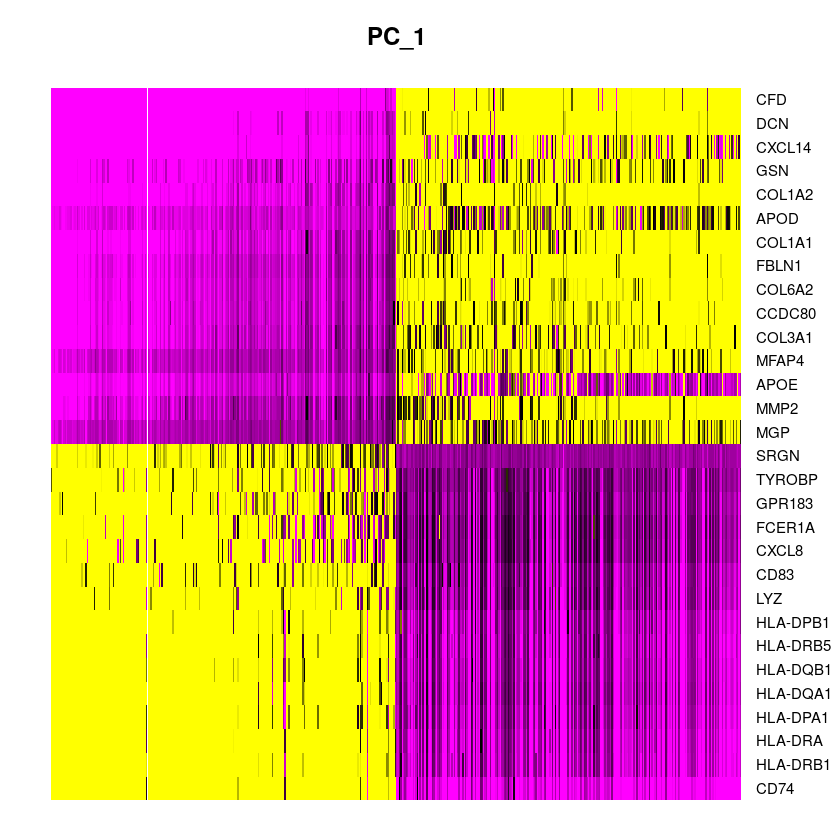

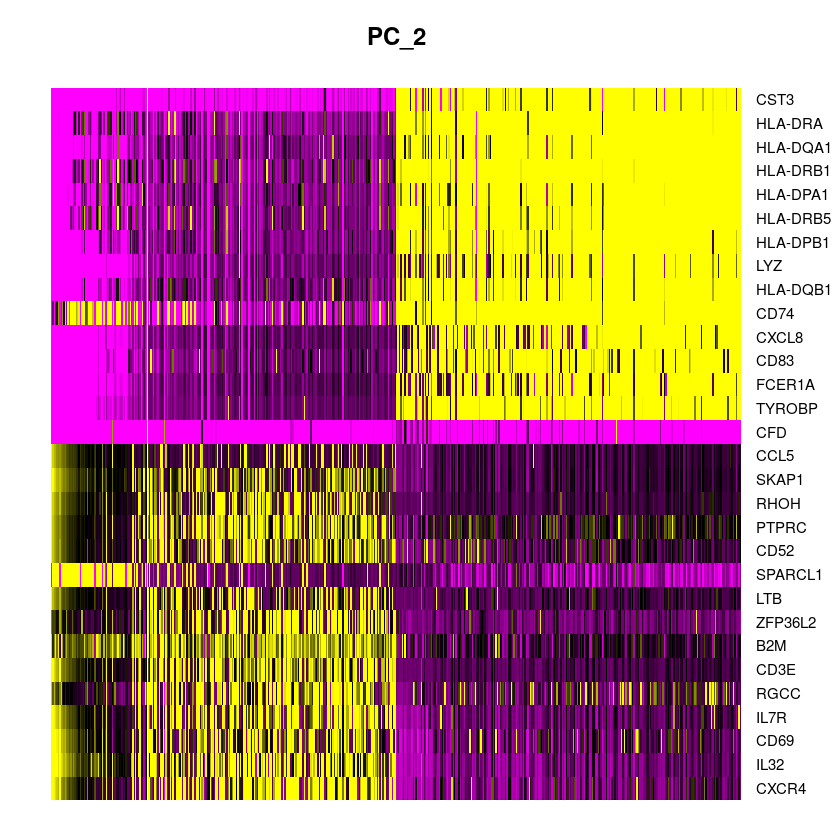

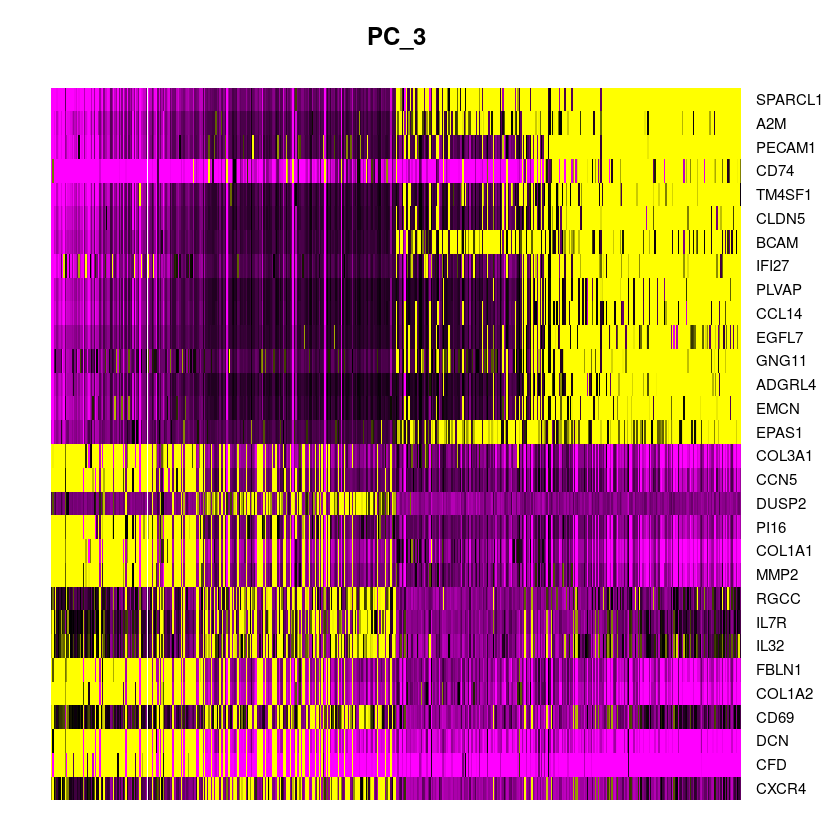

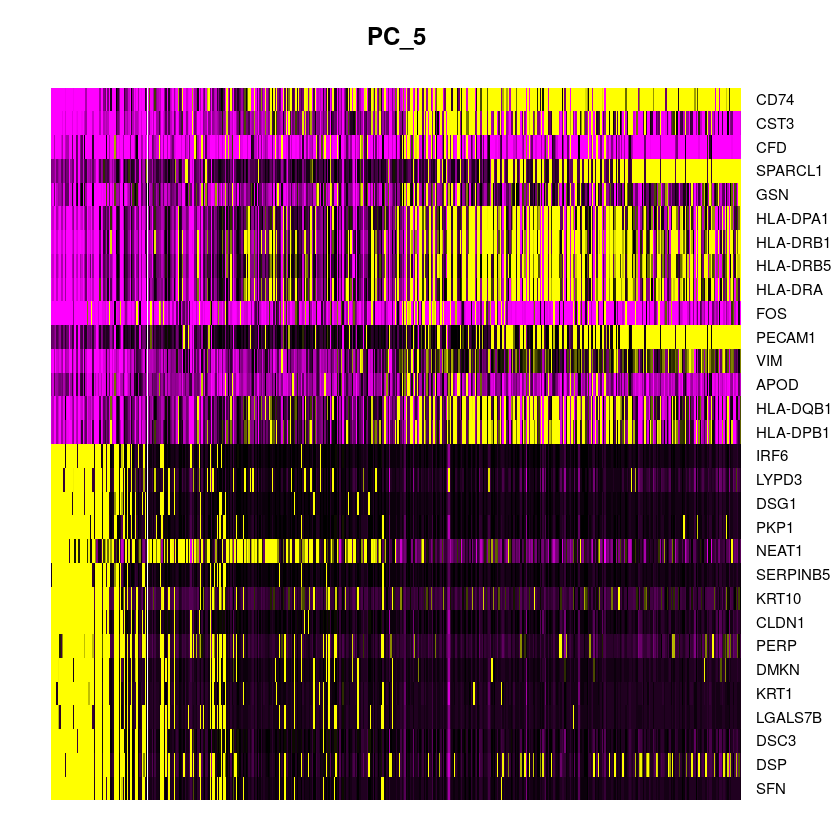

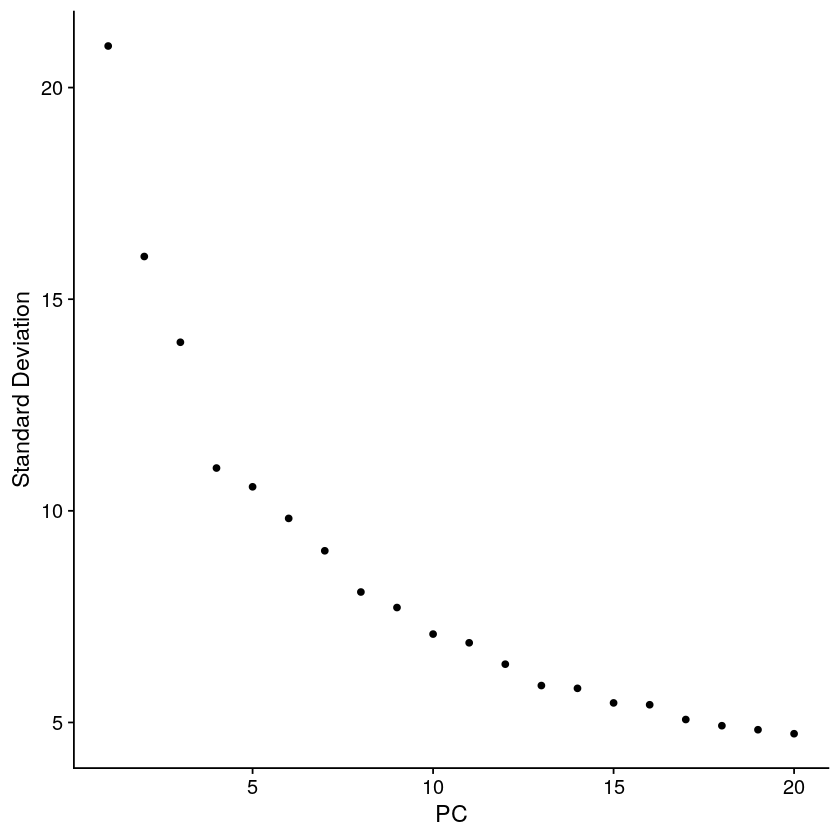

In [35]:
Seurat::DimHeatmap(dat1, dims =1 , cells = 500, balanced = TRUE)  ### plot the top 500 cells (highest scores)
Seurat::DimHeatmap(dat1, dims = 2, cells = 500, balanced = TRUE)  ### plot the top 500 cells (highest scores)
Seurat::DimHeatmap(dat1, dims = 3, cells = 500, balanced = TRUE)  ### plot the top 500 cells (highest scores)
Seurat::DimHeatmap(dat1, dims = 5, cells = 500, balanced = TRUE)  ### plot the top 500 cells (highest scores)
Seurat::ElbowPlot(dat1)

In [36]:
sig_PCs=c(1:12)
dat1 <- RunUMAP(dat1,dims = sig_PCs)
sce.seurat1=Seurat::FindNeighbors(dat1,reduction = "pca",k.param = 20,dims=sig_PCs) 
overview["HVG_thresh_type",2]=c("Seurat-SCT")
overview["HVG",2]=dim(sce.seurat1@reductions$pca@feature.loadings)[1]
overview["PCs",2]=max(sig_PCs)

10:02:32 UMAP embedding parameters a = 0.9922 b = 1.112

10:02:32 Read 3609 rows and found 12 numeric columns

10:02:32 Using Annoy for neighbor search, n_neighbors = 30

10:02:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:02:32 Writing NN index file to temp file /tmp/Rtmp2VRvhy/file3d23e270201f3

10:02:32 Searching Annoy index using 1 thread, search_k = 3000

10:02:33 Annoy recall = 100%

10:02:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:02:36 Initializing from normalized Laplacian + noise (using irlba)

10:02:36 Commencing optimization for 500 epochs, with 144402 positive edges

10:02:41 Optimization finished

Computing nearest neighbor graph

Computing SNN



png 
  2

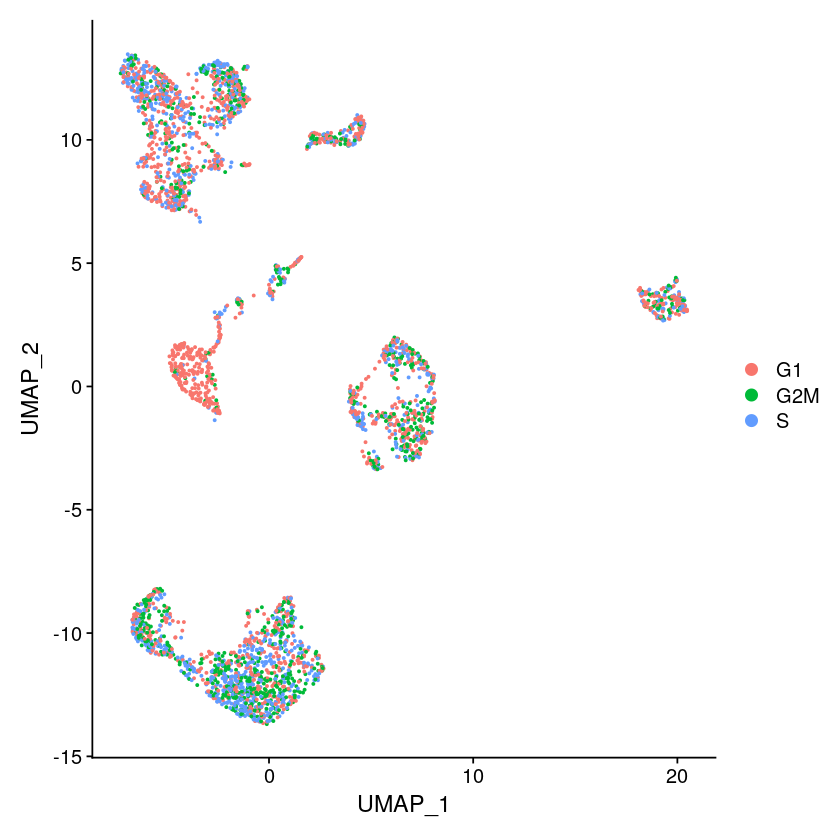

In [37]:
Idents(sce.seurat1)=as.factor(sce.seurat1@meta.data$Phase)
jpeg(paste0(out,sample_ID,"_cell_cycle.jpeg"))
UMAPPlot(sce.seurat1)
dev.off()
UMAPPlot(sce.seurat1)

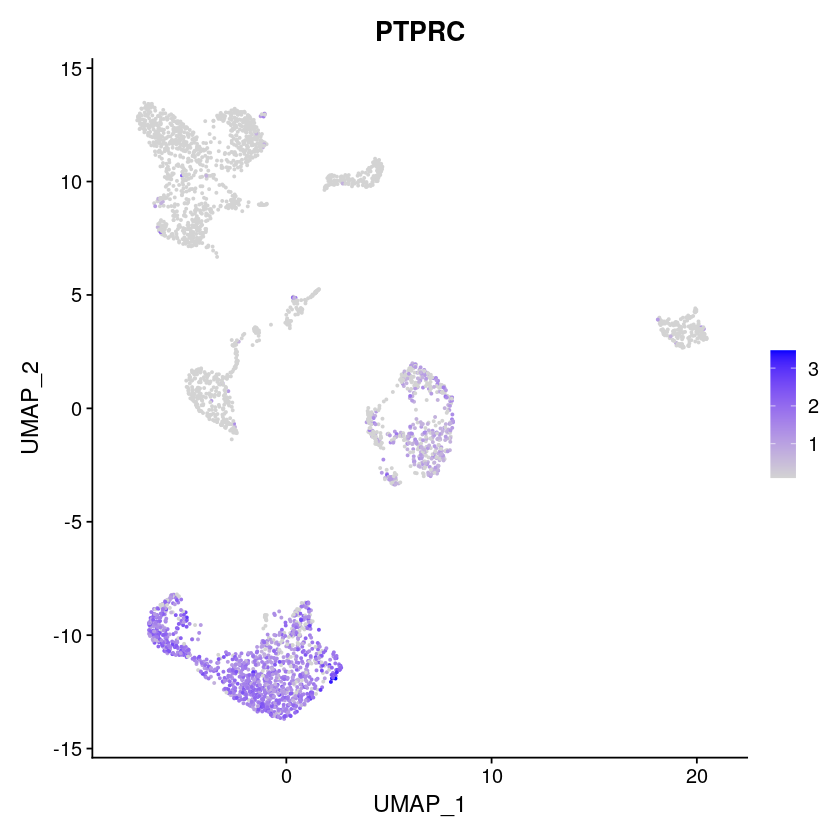

In [38]:
i=c("PTPRC")
p=FeaturePlot(sce.seurat1, features = as.character(i),min.cutoff=0.1,max.cutoff=5)
    print(p)

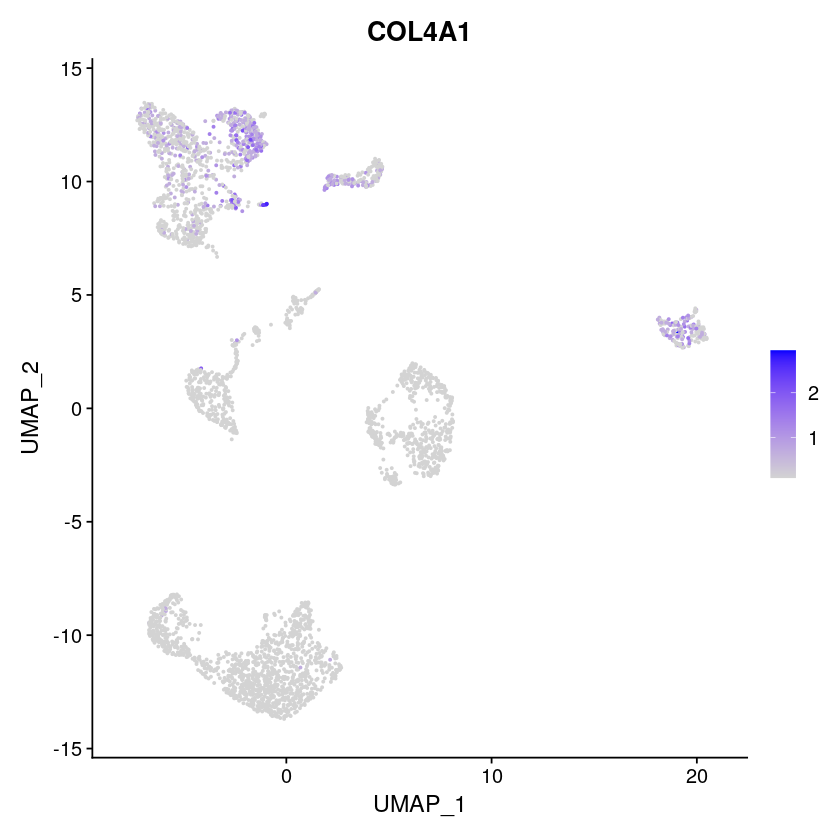

In [39]:
i=c("COL4A1")
p=FeaturePlot(sce.seurat1, features = as.character(i),min.cutoff=0.1,max.cutoff=5)
    print(p)

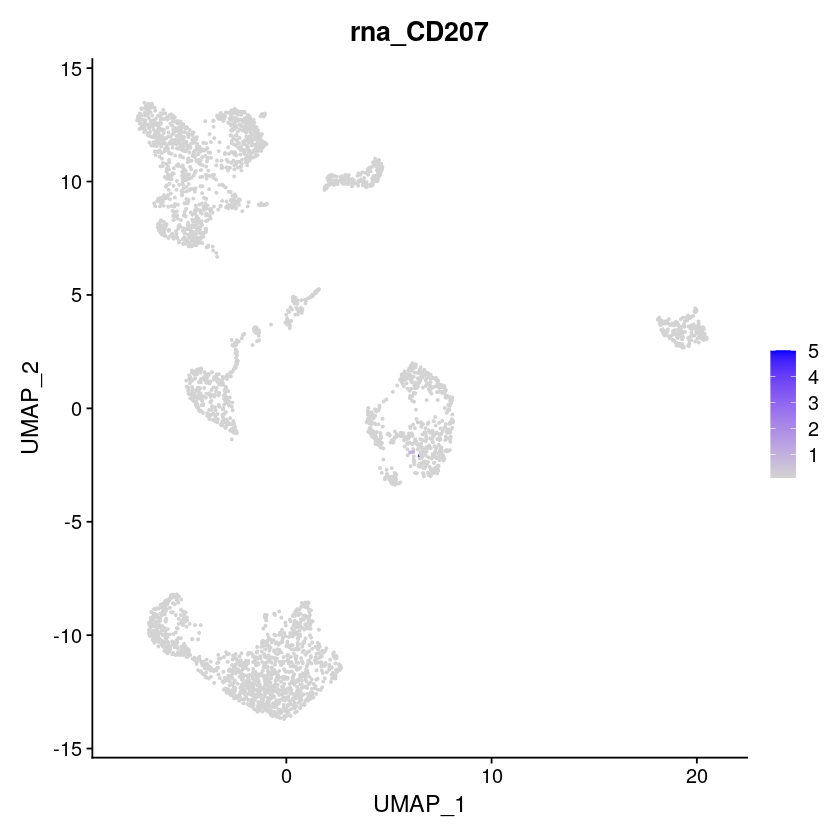

In [44]:
i=c("CD207")
p=FeaturePlot(sce.seurat1, features = as.character(i),min.cutoff=0.1,max.cutoff=5)
    print(p)

In [41]:
clust_test=function(sce) {
  cont=as.data.frame(matrix(NA,nrow=length(unique(Idents(sce))), ncol=4))
  colnames(cont)=c("cluster","cells","mean_total_UMI","mean_features")
  i=1
  for (k in unique(Idents(sce))) {
    print(c(k))
    cont[i,1]=c(k)
    dat23=sce@assays$RNA@counts[,Idents(sce)%in%c(k)]
    cont[i,2]=table(Idents(sce)%in%c(k))[2]
    cont[i,3]=mean(apply(dat23,2,function(x)sum(x)))
    cont[i,4]=mean(apply(dat23,2,function(x)table(x %in% c(0))[1]))
    i=i+1
  }
  cont=cont[order(as.numeric(as.character(cont$cluster))),]
  return(cont)
}

In [42]:
library("cowplot", lib.loc="/home/fs71707/dsam/R_packages/", character.only=TRUE)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3609
Number of edges: 111504

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9577
Number of communities: 11
Elapsed time: 0 seconds


png 
  2

[1] "3"
[1] "0"
[1] "1"
[1] "2"
[1] "7"
[1] "10"
[1] "5"
[1] "6"
[1] "9"
[1] "4"
[1] "8"


,cluster,cells,mean_total_UMI,mean_features
,<chr>,<int>,<dbl>,<dbl>
2,0,974,3104.653,1310.9959
3,1,489,6661.029,2428.3804
4,2,360,8218.044,2218.0639
1,3,291,2860.289,1271.6254
10,4,287,4808.627,1963.1359
7,5,267,1865.157,107.3483
8,6,219,4966.703,1954.8265
5,7,207,7544.203,2595.9517
11,8,187,9018.166,2775.4545


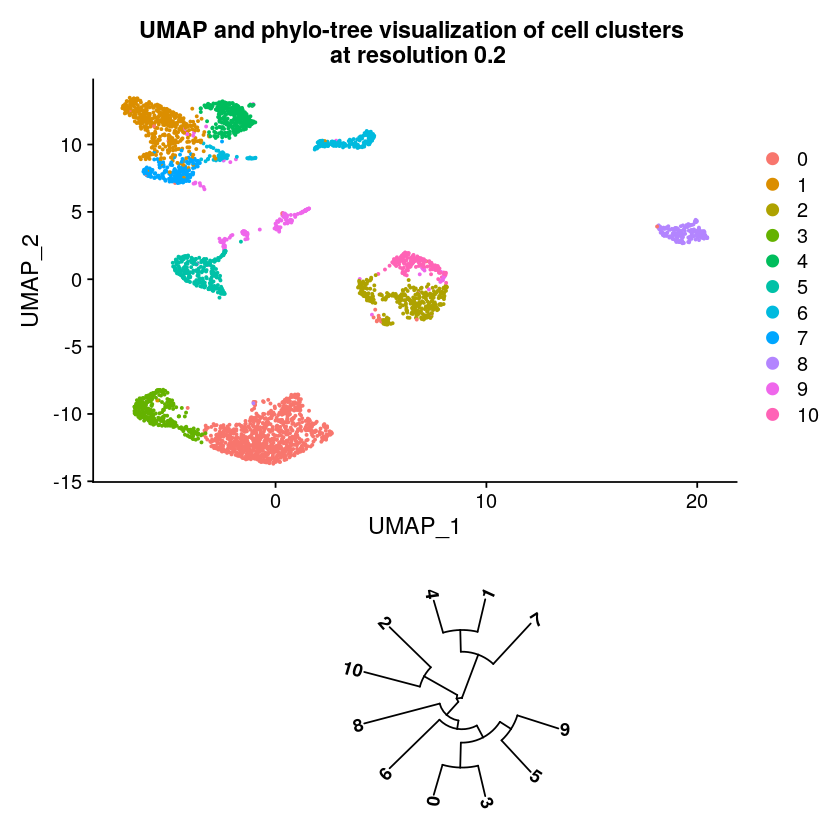

In [43]:
clust.res=0.2
sce.seurat1=Seurat::FindClusters(sce.seurat1,resolution=clust.res)  
sce.seurat1= Seurat::BuildClusterTree(sce.seurat1,dims=sig_PCs)
#sce.seurat1 <- RunUMAP(sce.seurat1, dims = sig_PCs)
tree1=sce.seurat1@tools$`Seurat::BuildClusterTree`
pl=Seurat::DimPlot(sce.seurat1, reduction = "umap")
pl= pl+ ggtitle(paste("UMAP and phylo-tree visualization of cell clusters \n at resolution",clust.res,sep=" ")) +
  theme (plot.title = element_text(color="black", size=14, face="bold",hjust = 0.5))
pl.matrix=ggplot_build(pl)$data[1][[1]]
uni_pl_mat=pl.matrix[!duplicated(pl.matrix$group),]
tr=ggtree(tree1,layout="circular") + geom_tiplab(aes(angle=angle), lwd=5,offset=.5,fontface="bold")  
plot_grid(pl, tr, align = "v", nrow = 2, rel_heights = c(2/3, 1/3),axis="l")    
jpeg(paste0(out,sample_ID,"CLUSTERING_OVERVIEW.jpeg"))
 plot_grid(pl, tr, align = "v", nrow = 2, rel_heights = c(2/3, 1/3),axis="l")
dev.off()
res1=clust_test(sce.seurat1)
res1

In [45]:
overview["cluster",2]=nrow(res1)
overview["resolution",2]=c(clust.res)
save(sce.seurat1,file=paste0(inter.dat,"Seurat_final_",sample_ID, ".RData"))
write.table(overview,file=paste0(inter.dat,"initialQC_",sample_ID,".txt"),sep="\t",col.names=T,row.names=F,quote=F)

## Association testing NOW !!

In [46]:
sce.seurat=sce.seurat1
clust.n=as.character(unique(Idents(sce.seurat)))
clust.size=table(Idents(sce.seurat))
clust.size

clust.n=as.character(unique(Idents(sce.seurat)))


  0   1   2   3   4   5   6   7   8   9  10 
974 489 360 291 287 267 219 207 187 179 149 

In [47]:
library("pROC",lib.loc = "/home/fs71707/dsam/R_packages2/", character.only = TRUE)
library("Matrix",lib.loc = "/home/fs71707/dsam/R_packages2/", character.only = TRUE)
library("enrichR",lib.loc = "/home/fs71707/dsam/R_packages2/", character.only = TRUE)

ERROR: Error in value[[3L]](cond): Package ‘Matrix’ version 1.5.1 cannot be unloaded:
 Error in unloadNamespace(package) : namespace ‘Matrix’ is imported by ‘irlba’, ‘BiocSingular’, ‘HDF5Array’, ‘bluster’, ‘survival’, ‘BiocNeighbors’, ‘DelayedMatrixStats’, ‘uwot’, ‘leiden’, ‘spatstat.data’, ‘sctransform’, ‘spatstat.sparse’, ‘scuttle’, ‘mgcv’, ‘scater’, ‘SummarizedExperiment’, ‘SeuratObject’, ‘sparseMatrixStats’, ‘spatstat.core’, ‘beachmat’, ‘DelayedArray’, ‘rsvd’, ‘Seurat’, ‘scran’, ‘xgboost’, ‘ScaledMatrix’, ‘DropletUtils’, ‘scDblFinder’, ‘reticulate’ so cannot be unloaded



In [ ]:
# ====================================.  prep input data
clust.n=as.character(unique(Idents(sce.seurat)))
clust.size=table(Idents(sce.seurat))
clust.size
max_per_cluster=c(5000)  
clust.n=as.character(unique(Idents(sce.seurat)))
rm(res_wilcox)

### ---------------------------------------------   one vs one for all cluster
for (i in clust.n) {        ##  case loop
     contr.clust=clust.n[!clust.n %in% i]
    for (k in contr.clust) {    ## contr loop
        if (i == k) {
            next
        }  
         print(paste("computing markers for cluster", i,"compared to",k,"now!!!", sep=" "))
          seurat_cluster_0 = FindMarkers(sce.seurat, ident.1 = i, ident.2 = k,test.use = "wilcox",
                                 logfc.threshold = 0.15,max.cells.per.ident = max_per_cluster,
                                min.cells.group=30,only.pos = TRUE)  # min.pct = 0.3
          seurat_cluster_0=seurat_cluster_0[seurat_cluster_0$p_val_adj < 0.05,]
        seurat_cluster_0$ID=as.character(rownames(seurat_cluster_0))
          seurat_cluster_0$case_CLUSTER=rep(i,nrow(seurat_cluster_0))
          seurat_cluster_0$contr_CLUSTER=rep(k,nrow(seurat_cluster_0))
          seurat_cluster_0$clust_size=rep(as.numeric(clust.size[i]),nrow(seurat_cluster_0))
          sce.case=sce.seurat[rownames(sce.seurat) %in%  as.character(seurat_cluster_0$ID),Idents(sce.seurat)%in%c(i)]
          sce.contr=sce.seurat[rownames(sce.seurat) %in%  as.character(seurat_cluster_0$ID),Idents(sce.seurat)%in%c(k)]
            seurat_cluster_0=seurat_cluster_0[as.character(rownames(sce.case)), ]
            seurat_cluster_0$case_total_umi=Matrix::rowSums(sce.case@assays$RNA@counts)
            seurat_cluster_0$contr_total_umi=Matrix::rowSums(sce.contr@assays$RNA@counts)
            ##.   ------------- get AUC
            auc.sce=merge(sce.case,sce.contr)
            seurat_cluster_0=seurat_cluster_0[as.character(rownames(auc.sce)), ]
            response=rep(1,length(Idents(auc.sce)))                                       
            response[Idents(auc.sce)%in% c(i)]=2
            seurat_cluster_0$AUC=apply(auc.sce@assays$SCT@data,1,function(x)auc(response,as.numeric(x),quiet=T,allow.invalid.partial.auc.correct=F))             
        if(!exists("res_wilcox")){
            res_wilcox=seurat_cluster_0
          }else {
            res_wilcox=rbind(res_wilcox,seurat_cluster_0)
          }
      rm(seurat_cluster_0,response,sce.contr,sce.case,auc.sce)
    } ## contr loop
}  ## case loop                                                                  


  0   1   2   3   4   5   6   7   8   9  10 
974 489 360 291 287 267 219 207 187 179 149 

In [ ]:
save(res_wilcox,file=paste(out,"ASSOC_result_cluster_",sample_ID, ".RData"))
head(res_wilcox)

In [20]:
enrich.lists=c('WikiPathways_2019_Human','KEGG_2019_Human' ,'Reactome_2016','BioPlanet_2019','Human_Gene_Atlas','ARCHS4_Tissues',
               'Mouse_Gene_Atlas','GO_Biological_Process_2018','GO_Molecular_Function_2018','MSigDB_Hallmark_2020')
screen.overlaps=c('MSigDB_Hallmark_2020','Human_Gene_Atlas','ARCHS4_Tissues','Mouse_Gene_Atlas','KEGG_2019_Human')
###      ----------------------   NEW CURRENT VERSION.  !!!!!!!!!
tiering_thresh=data.frame(case_perc=c(0.5,0.3),contr_perc=c(0.05,0.05))
AUC_tier3=c(0.7)
lgFC_tier3=c(0.25)
maxCONTR=length(unique(res_wilcox$contr_CLUSTER))-1
markerN=5
### ----------------------------- tiering function
tiering=function(dat,markerN){
    dat=dat[order(-dat$AUC),]
    order.ID=dat$ID[!duplicated(dat$ID)]   ### returns them in order of apperance !
    ok.ID=order.ID[1:markerN]
    dat12=dat[dat$ID %in% as.character(ok.ID),]
return(dat12)
}
##------------------------------------------
all.cases=unique(res_wilcox$case_CLUSTER)
for (k in all.cases) {
    print(noquote(c('--------------------------------------------------------------------------------')))
    print(noquote(paste0("--------------   processing cluster ",k," as CASES now !!   ------------------------")))
    ## -------------------------------------------------------  prep full MACR dataset
    inter=res_wilcox[res_wilcox$case_CLUSTER %in% k,]
    dim(inter)
    for (t in c("TIER","DUPL","nameCONT","panel","panel_descr",unique(inter$contr_CLUSTER))){
        inter[,t]=NA
    } 
    ### ---------------------------------------------   start
    rm(final.out)
    for (tier in c(1,2)){
        if (!exists("final.out")){
            int.t1a=inter[inter$pct.1>tiering_thresh[tier,1] & inter$pct.2 < tiering_thresh[tier,2],]
            int.t1a$TIER=c(tier)
        } else if (tier %in% c(2)) {
            inter1=inter[!(inter$ID %in% final.out$ID),]
            int.t1a=inter1[inter1$pct.1>tiering_thresh[tier,1] & inter1$pct.2 < tiering_thresh[tier,2],]
            int.t1a$TIER=c(tier)
        } else if ( tier %in% c(3)){
            inter1=inter[!(inter$ID %in% final.out$ID),]
            #int.t1a=inter1[inter1$AUC> as.numeric(AUC_tier3) & inter1$avg_logFC > lgFC_tier3,]
            int.t1a=inter1[inter1$avg_logFC > lgFC_tier3,]
            int.t1a$TIER=c(tier)
        }
    ### ------------   prep data per TIER
        rm(int.t1)
        for (kt in unique(int.t1a$ID)) {
            int2=int.t1a[int.t1a$ID %in% kt,]
            entr=as.character(int2$contr_CLUSTER)
            int2$DUPL=length(entr)
            int2$nameCONT = paste(entr,sep='',collapse=" | ")
            for (j in entr) {
                int2[,j]=c(1)
                }  
            if(!exists("int.t1")){
                int.t1=int2
                }else {
                int.t1=rbind(int.t1,int2) 
            }
        }
    ### -------------------------------------
    ### create panels -- per TIER   
        spec=NA
        for (r in maxCONTR:1) {  
            dat=int.t1[int.t1$DUPL %in% r,]
            #print (paste("this is control ", r, sep=" "))
            if (max(int.t1$DUPL) < r) {  
                #print (paste("skip ",r ,"!!!"))
                next 
                } else if (any(dat$DUPL %in% maxCONTR)) {
                        #print (c("found a lot of data"))         
                        dat12=tiering(dat,markerN)
                        spec=c(spec,as.character(dat12$contr_CLUSTER))
                        int.t1$panel[int.t1$ID %in% unique(dat12$ID)]=paste0("TIER",tier,"_panel")        
                    } ### a lot of data else if
                    else if (nrow(dat) > 1 & length(spec)<2){
                        #print (c("found data for the first time"))   
                        dat12=tiering(dat,markerN)
                        spec=c(spec,as.character(dat12$contr_CLUSTER))
                        int.t1$panel[int.t1$ID %in% unique(dat12$ID)]=paste0("TIER",tier,"_panel")   
                      }
                    else if (nrow(dat) > 1){
                       # print (c("found data !!!")) 
                        freq.t=as.data.frame(table(spec))
                        stay.in=freq.t$spec[freq.t$Freq < markerN]
                        dat=dat[dat$contr_CLUSTER %in% stay.in, ]
                        if (nrow(dat) > 1){
                            dat12=tiering(dat,markerN)
                            spec=c(spec,as.character(dat12$contr_CLUSTER))
                            int.t1$panel[int.t1$ID %in% unique(dat12$ID)]=paste0("TIER",tier,"_panel") 
                        } else { next }
                    }
        } # for loop
###. -------
        fin.int=as.data.frame(table(int.t1$contr_CLUSTER[!is.na(int.t1$panel)]))
        zeros=unique(inter$contr_CLUSTER)[!(unique(inter$contr_CLUSTER) %in% fin.int$Var1)]
        if (length(zeros >0)){
            fin.int=rbind(fin.int,data.frame(Var1=zeros,Freq=rep(0,length(zeros))))
        }
        pan.descr=paste(paste(fin.int$Freq, fin.int$Var1,sep="x"),sep="",collapse=" ")
        int.t1$panel_descr[int.t1$panel %in% paste0("TIER",tier,"_panel")] = c(pan.descr)  
## 
        print(noquote(paste0(" TIER ",tier, " Markerpanel:")))
        print(noquote(paste(unique(int.t1$ID[int.t1$panel %in% paste0("TIER",tier,"_panel") ]))))
        if(!exists("final.out")){
            final.out=int.t1
        } else {
            final.out=rbind(final.out,int.t1)
        }
    } # close tiering loop
    assign(paste0("all_tiers_", k), final.out)  ### keep this for phenotype loop
    write.table(final.out,file=paste0(out,"MARKERS_specific_",k,"_allTIERs.txt"),sep="\t",col.names=T,row.names=F,quote=F)
    print(noquote(paste0('written to file: ', out,"MARKERS_specific_",k,"_allTIERs.txt")))
####.  ----------------------------------   run enrichment
    dat1=final.out[final.out$TIER %in% c("1","2"),]
    g.list=dat1$ID[!duplicated(dat1$ID)]
    invisible(capture.output(enr.result <- enrichr(as.character(g.list),enrich.lists)))
#####.  ---------------------------------    screen overlaps and create list
    for (over in enrich.lists) {
        if(over %in% screen.overlaps){
            print(noquote(paste("           ++++++++ cluster",k, "overlaps to",over,"++++++++     ")))
            print(noquote((enr.result)[[over]][1:5,c(1,2,4)]))
        }
        inter=head((enr.result)[[over]],n=20)
        if (!exists("over.fin")){
            over.fin=inter
        }else {
            over.fin=as.data.frame(rbind(over.fin, inter))
            }
        }
    write.table(over.fin,file=paste0(out,"OVERLAPS_specific_",k,"_TIER_1_2.txt"),sep="\t",col.names=T,row.names=F,quote=F)
    print(noquote(paste0('written to file: ', out,"OVERLAPS_specific_",k,"_TIER_1_2.txt")))
    rm(over.fin)
    
}          

[1] --------------------------------------------------------------------------------
[1] --------------   processing cluster 4 as CASES now !!   ------------------------


Warning message in rm(final.out):
“object 'final.out' not found”
Warning message in rm(int.t1):
“object 'int.t1' not found”


[1]  TIER 1 Markerpanel:
 [1] PDZK1IP1 TP63     FGFBP1   PDLIM1   COL17A1  MKI67    SOX15    CCL2    
 [9] SERPINB2 STMN1    DST      IFITM1  
[1]  TIER 2 Markerpanel:
[1] WNT4     DAPL1    ANLN     TP53AIP1 TNS4     KRT15    ITGB4   
[1] written to file: /home/fs71707/mwielsch1/data/jupyter_data/DARC/result/MARKERS_specific_4_allTIERs.txt
[1]            ++++++++ cluster 4 overlaps to KEGG_2019_Human ++++++++     
                              Term Overlap Adjusted.P.value
1          Proteoglycans in cancer  11/201     0.0001076702
2                   Bladder cancer    6/41     0.0001076702
3            p53 signaling pathway    7/72     0.0001521800
4                   Focal adhesion   9/199     0.0022433552
5 Regulation of actin cytoskeleton   9/214     0.0027109771
[1]            ++++++++ cluster 4 overlaps to Human_Gene_Atlas ++++++++     
                      Term Overlap Adjusted.P.value
1 BronchialEpithelialCells  23/280     7.153464e-15
2                   Tongue  10/115     1.

In [ ]:
i=c("ADGRL4")
p=FeaturePlot(sce.seurat1, features = as.character(i),min.cutoff=0.1,max.cutoff=5)
    print(p)